In [1]:
import sys
sys.path.append("...")
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.config import ACTIVITIES, ABBR, TZ_PARIS, TZ_LONDON
from src.viz_style import apply_nature_style

apply_nature_style()

In [3]:
from src.utils_time import to_local_time_series, split_cross_midnight, week_start_monday
from src.utils_split import split_users_by_hash
from src.regularity import regularity_report, summarize_reg, compute_user_hex_stats, infer_home_work_anchors, make_hex_lookup

In [4]:
from pathlib import Path

ROOT = Path("...")
OUT_DATA = ROOT / "outputs" / "data"
OUT_FIG = ROOT / "outputs" / "figures"
OUT_TAB = ROOT / "outputs" / "tables"
OUT_FIG.mkdir(parents=True, exist_ok=True)
OUT_TAB.mkdir(parents=True, exist_ok=True)

def prep_stays(df):
    d = df.copy()
    if "user_id" not in d.columns and "userid" in d.columns:
        d = d.rename(columns={"userid":"user_id"})
    d["user_id"] = d["user_id"].astype(str)
    d["start_time"] = pd.to_datetime(d["start_time"])
    d["end_time"] = pd.to_datetime(d["end_time"])
    if "duration_min" not in d.columns:
        d["duration_min"] = (d["end_time"] - d["start_time"]).dt.total_seconds()/60.0
    d["hex_id"] = d["hex_id"].astype(str).replace({"": np.nan, "nan": np.nan})
    d = d.dropna(subset=["hex_id","start_time","end_time"]).copy()
    d = d[d["duration_min"] > 0].copy()
    return d

paris_train = prep_stays(pd.read_parquet(OUT_DATA / "paris_stays_train.parquet"))
paris_valid = prep_stays(pd.read_parquet(OUT_DATA / "paris_stays_valid.parquet"))
paris_all = pd.concat([paris_train, paris_valid], ignore_index=True)

uk_1w_path = sorted(OUT_DATA.glob("uk_london_stays_1w_u*.parquet"))[-1]
uk_1m_path = sorted(OUT_DATA.glob("uk_london_stays_1m_u*.parquet"))[-1]
uk_3m_path = sorted(OUT_DATA.glob("uk_london_stays_3m_u*.parquet"))[-1]

uk_1w = prep_stays(pd.read_parquet(uk_1w_path))
uk_1m = prep_stays(pd.read_parquet(uk_1m_path))
uk_3m = prep_stays(pd.read_parquet(uk_3m_path))

print("Paris all:", len(paris_all), "users:", paris_all["user_id"].nunique())
print("UK 1W:", len(uk_1w), "users:", uk_1w["user_id"].nunique())
print("UK 1M:", len(uk_1m), "users:", uk_1m["user_id"].nunique())
print("UK 3M:", len(uk_3m), "users:", uk_3m["user_id"].nunique())

Paris all: 62240 users: 3103
UK 1W: 5946 users: 231
UK 1M: 24782 users: 231
UK 3M: 61523 users: 231


In [5]:
paris_reg = regularity_report(paris_all, name="PARIS_ALL")
uk_1w_reg = regularity_report(uk_1w, name="LONDON_1W")
uk_1m_reg = regularity_report(uk_1m, name="LONDON_1M")
uk_3m_reg = regularity_report(uk_3m, name="LONDON_3M")

summary = pd.DataFrame([
    summarize_reg("PARIS_ALL", paris_all, paris_reg),
    summarize_reg("LONDON_1W", uk_1w, uk_1w_reg),
    summarize_reg("LONDON_1M", uk_1m, uk_1m_reg),
    summarize_reg("LONDON_3M", uk_3m, uk_3m_reg),
])

summary_path = OUT_TAB / "data_compare_regularity_summary.csv"
summary.to_csv(summary_path, index=False)
print("Saved:", summary_path)
summary


===== PARIS_ALL regularity report =====
rows: 62240 users: 3103

===== LONDON_1W regularity report =====
rows: 5946 users: 231

===== LONDON_1M regularity report =====
rows: 24782 users: 231

===== LONDON_3M regularity report =====
rows: 61523 users: 231
Saved: /Users/pang/Codes/GISRUK/outputs/tables/data_compare_regularity_summary.csv


,dataset,users,calendar_days,stays,user_days_med,stays/user/day_med,stays/user/day_p90,top1_share_med,top3_share_med,unique_hex_med,max_visit_days_med,night_stability_med
0,PARIS_ALL,3103,162,62240,6.0,3.285714,5.000000,0.287493,0.633070,15.0,3.0,0.333333
1,LONDON_1W,231,7,5946,7.0,3.714286,6.000000,0.839904,0.979966,8.0,6.0,1.000000
2,LONDON_1M,231,30,24782,27.0,3.700000,5.833333,0.832221,0.961501,23.0,26.0,0.960000
3,LONDON_3M,231,81,61523,70.0,3.670886,5.500000,0.841902,0.955865,44.0,67.0,0.933333


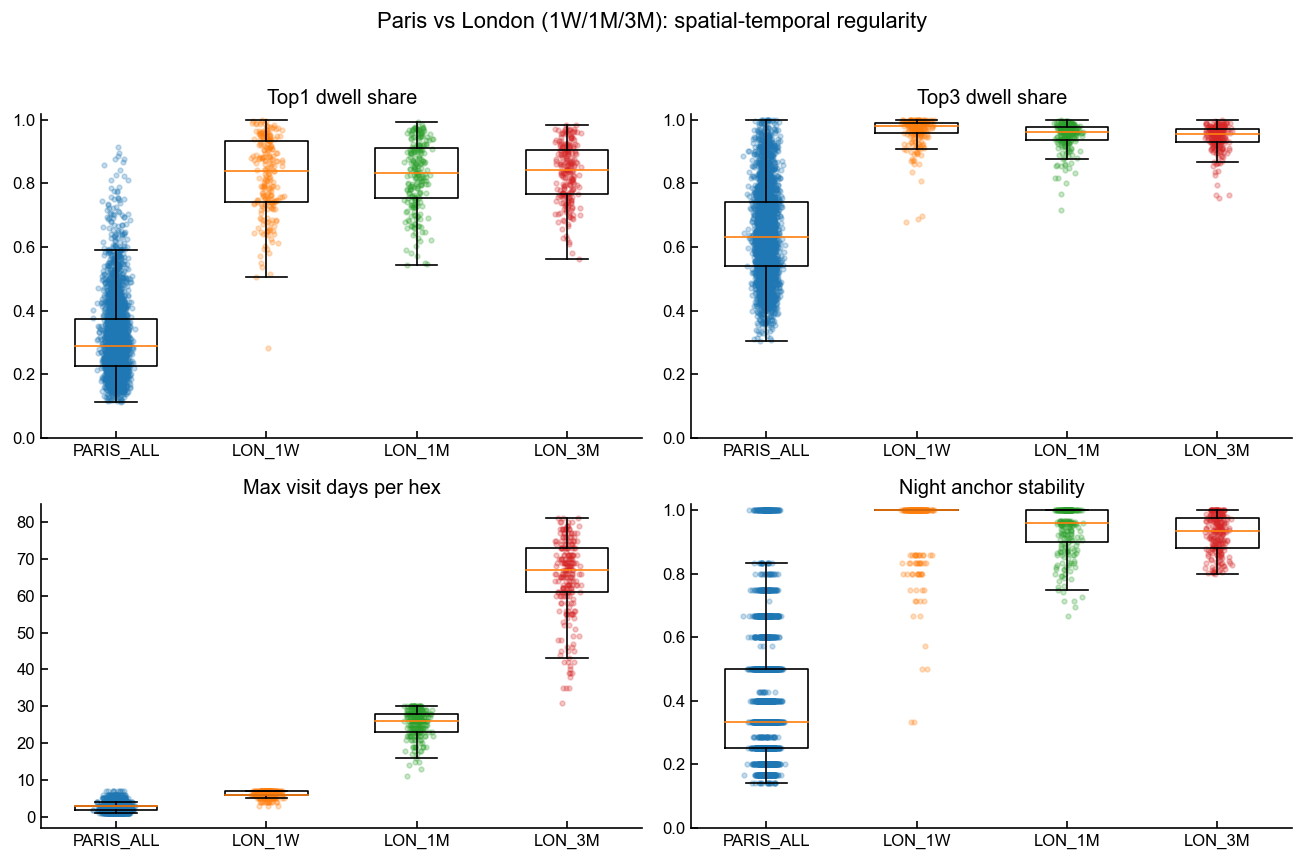

Saved: /Users/pang/Codes/GISRUK/outputs/figures/regularity_panel_paris_vs_london.png


In [6]:
def extract_metric_series(reg_obj, metric):
    top = reg_obj.get("top", None) or reg_obj.get("top_shares", None)
    if metric == "top1_share":
        return top["top1_share"].dropna().astype(float)
    if metric == "top3_share":
        return top["top3_share"].dropna().astype(float)
    if metric == "max_visit_days":
        return pd.Series(reg_obj["max_visit_days"]).dropna().astype(float)
    if metric == "night_stability":
        return pd.Series(reg_obj["night_anchor_stability"]).dropna().astype(float)
    raise ValueError(metric)

def boxstrip(ax, series_list, labels, seed=0):
    rng = np.random.default_rng(seed)
    pos = np.arange(1, len(series_list)+1)
    vals = [s.values for s in series_list]

    ax.boxplot(vals, positions=pos, widths=0.55, showfliers=False)
    for i, v in enumerate(vals, start=1):
        x = i + rng.normal(0, 0.04, size=len(v))
        ax.scatter(x, v, s=8, alpha=0.25)

    ax.set_xticks(pos)
    ax.set_xticklabels(labels, rotation=0)
    ax.tick_params(direction="in")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

apply_nature_style()

datasets = ["PARIS_ALL","LON_1W","LON_1M","LON_3M"]
reg_map = {"PARIS_ALL": paris_reg, "LON_1W": uk_1w_reg, "LON_1M": uk_1m_reg, "LON_3M": uk_3m_reg}

fig, axes = plt.subplots(2,2, figsize=(11,7))
axes = axes.flatten()

metrics = [
    ("top1_share", "Top1 dwell share"),
    ("top3_share", "Top3 dwell share"),
    ("max_visit_days", "Max visit days per hex"),
    ("night_stability", "Night anchor stability"),
]

for ax, (mkey, title) in zip(axes, metrics):
    series_list = [extract_metric_series(reg_map[d], mkey) for d in datasets]
    boxstrip(ax, series_list, datasets)
    ax.set_title(title)
    if "share" in mkey or "stability" in mkey:
        ax.set_ylim(0, 1.02)

fig.suptitle("Paris vs London (1W/1M/3M): spatial-temporal regularity", y=1.02)
plt.tight_layout()
out_panel = OUT_FIG / "regularity_panel_paris_vs_london.png"
fig.savefig(out_panel, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print("Saved:", out_panel)

In [7]:
def quick_label_hw_other(stays_df):
    hs = compute_user_hex_stats(stays_df)
    anchors = infer_home_work_anchors(hs)
    home_lookup = dict(zip(anchors["user_id"], anchors["home_hex"]))
    work_lookup = dict(zip(anchors["user_id"], anchors["work_hex"]))

    d = stays_df.copy()
    d["y_true"] = "OTHER"
    d.loc[d["hex_id"].astype(str) == d["user_id"].map(home_lookup).astype(str), "y_true"] = "HOME"
    d.loc[d["hex_id"].astype(str) == d["user_id"].map(work_lookup).astype(str), "y_true"] = "WORK"
    return d

uk_1w_q = quick_label_hw_other(uk_1w)

In [8]:
from src.utils_time import to_local_time_series, split_cross_midnight
from src.config import ABBR, TZ_LONDON

def collapse_consecutive(labels):
    out=[]
    for x in labels:
        if len(out)==0 or x!=out[-1]:
            out.append(x)
    return out

def build_daily_patterns(stays_df, label_col="y_true", min_dur_min=10, require_home_sandwich=False,
                         tz=TZ_LONDON, assume_utc_if_naive=True):
    """
    Build daily activity patterns (one pattern per user-day).
    Uses DST-safe to_local_time_series and splits cross-midnight intervals.
    """
    d = stays_df.copy()
    d["start_time"] = to_local_time_series(d["start_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
    d["end_time"]   = to_local_time_series(d["end_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
    d["duration_min"] = pd.to_numeric(d["duration_min"], errors="coerce")
    d = d.dropna(subset=["user_id","start_time","end_time","duration_min",label_col]).copy()
    d = d[d["duration_min"] > 0].copy()

    d = split_cross_midnight(d)
    d = d[d["duration_min"] >= float(min_dur_min)].copy()

    d["date"] = d["start_time"].dt.date
    d["dow"] = d["start_time"].dt.weekday

    rows=[]
    for (u, date), g in d.groupby(["user_id","date"], sort=False):
        g = g.sort_values("start_time")
        labs = [x for x in g[label_col].astype(str).tolist() if x in ABBR]
        if not labs:
            continue
        labs2 = collapse_consecutive(labs)
        if require_home_sandwich and not (labs2[0]=="HOME" and labs2[-1]=="HOME"):
            continue
        patt = "-".join([ABBR[x] for x in labs2])
        rows.append((u, date, int(g["dow"].iloc[0]), patt))
    return pd.DataFrame(rows, columns=["user_id","date","dow","pattern"])


def plot_patterns_by_dow_small_multiples(patterns_df, coverage=0.90, max_n=12, min_count=10,
                                        title="Daily activity patterns by day-of-week",
                                        outpath=None):
    apply_nature_style()
    dow_names = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

    keep = select_patterns_by_coverage(patterns_df, coverage=coverage, max_n=200, min_count=min_count)
    tmp = patterns_df.copy()
    tmp["pattern2"] = tmp["pattern"].where(tmp["pattern"].isin(keep), other="Other")

    global_counts = tmp["pattern2"].value_counts()
    ordered = global_counts.index.tolist()
    top_order = [p for p in ordered if p != "Other"][:max_n]
    if "Other" in ordered:
        top_order = top_order + ["Other"]

    tab = tmp.groupby(["dow","pattern2"]).size().unstack(fill_value=0).reindex(index=range(7), fill_value=0)
    tab = tab.reindex(columns=top_order, fill_value=0)
    share = tab.div(tab.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)

    fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharey=True)
    axes = axes.flatten()
    x = np.arange(len(top_order))

    for d in range(7):
        ax = axes[d]
        ax.bar(x, share.loc[d].values, alpha=0.9)
        ax.set_title(dow_names[d])
        ax.set_ylim(0, min(1.0, float(share.values.max())*1.15 + 0.02))
        ax.tick_params(direction="in")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_xticks(x)
        ax.set_xticklabels(top_order, rotation=45, ha="right")
        if d % 4 == 0:
            ax.set_ylabel("Share of user-days")

    axes[7].axis("off")
    fig.suptitle(title, y=1.02)

    legend_text = "H=Home, W=Work, S=Study, P=Purchase, L=Leisure, He=Health, O=Other"
    fig.text(0.98, 0.02, legend_text, ha="right", va="bottom", fontsize=11)
    fig.subplots_adjust(hspace=0.40, wspace=0.05)

    plt.tight_layout()
    if outpath:
        plt.savefig(outpath, dpi=300, bbox_inches="tight")
        print("Saved:", outpath)
    plt.show()
    plt.close(fig)

    return share, top_order


def select_patterns_by_coverage(patterns_df, coverage=0.90, max_n=200, min_count=10):
    vc = patterns_df["pattern"].value_counts()
    vc = vc[vc >= min_count]
    cum = vc.cumsum() / vc.sum()
    selected = vc.index[cum <= coverage].tolist()
    if len(selected) == 0:
        selected = vc.head(min(max_n, len(vc))).index.tolist()
    else:
        selected = selected[:max_n]
    return selected

Saved: /Users/pang/Codes/GISRUK/outputs/figures/paris_patterns_by_dow.png


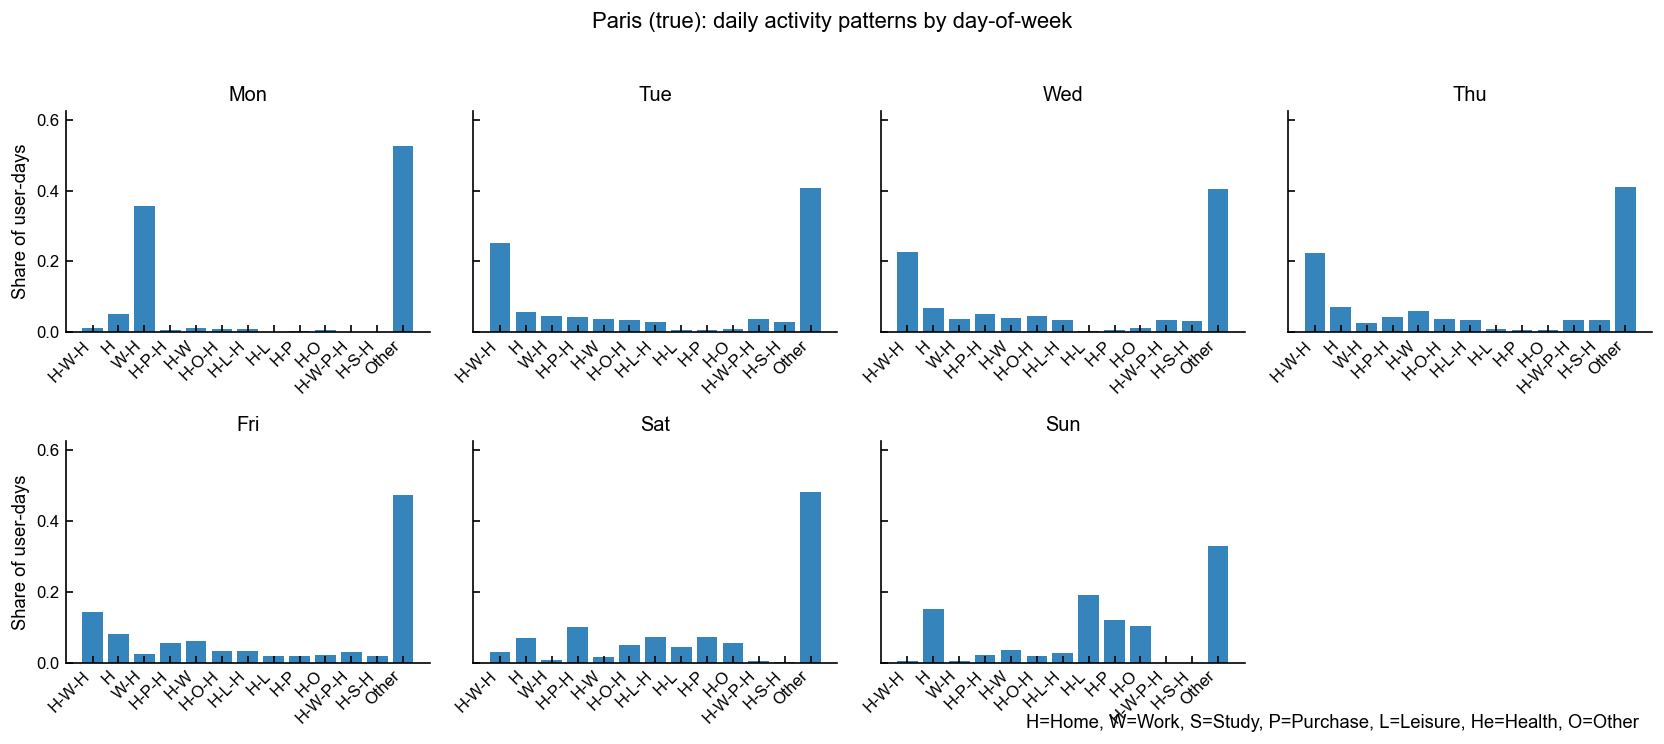

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_quick_patterns_by_dow.png


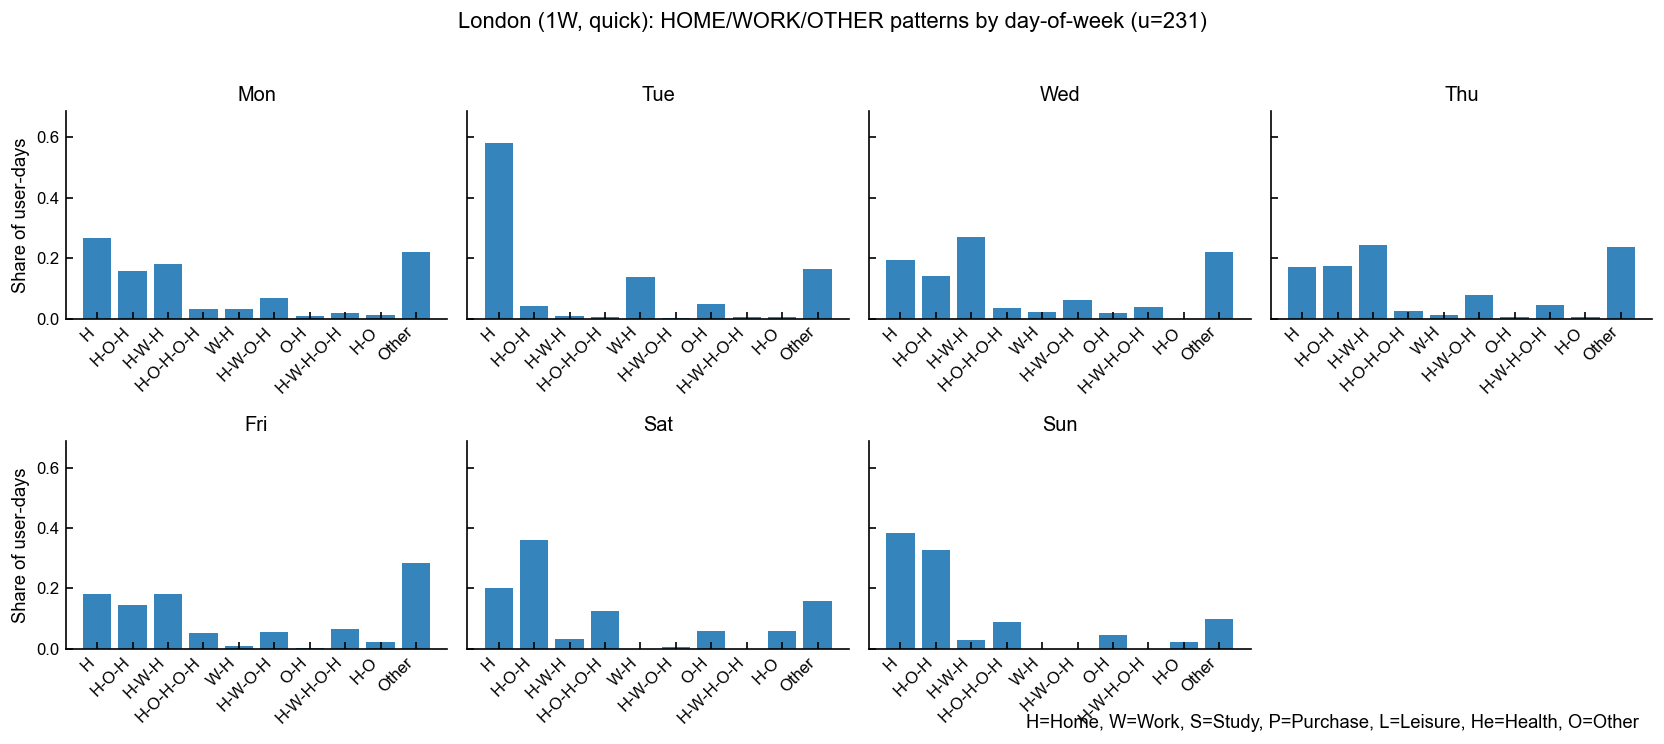

(pattern2         H     H-O-H     H-W-H  H-O-H-O-H       W-H   H-W-O-H  \
 dow                                                                     
 0         0.266968  0.158371  0.180995   0.031674  0.031674  0.067873   
 1         0.580336  0.043165  0.009592   0.004796  0.136691  0.002398   
 2         0.192982  0.140351  0.271930   0.035088  0.021930  0.061404   
 3         0.171053  0.175439  0.245614   0.026316  0.013158  0.078947   
 4         0.182609  0.143478  0.182609   0.052174  0.008696  0.056522   
 5         0.202703  0.360360  0.031532   0.126126  0.000000  0.004505   
 6         0.383886  0.327014  0.028436   0.090047  0.000000  0.000000   
 
 pattern2       O-H  H-W-H-O-H       H-O     Other  
 dow                                                
 0         0.009050   0.018100  0.013575  0.221719  
 1         0.047962   0.004796  0.004796  0.165468  
 2         0.017544   0.039474  0.000000  0.219298  
 3         0.004386   0.043860  0.004386  0.236842  
 4         0.0

In [9]:
# Paris patterns (true labels y_true)
patterns_paris = build_daily_patterns(paris_all, label_col="y_true", min_dur_min=10, require_home_sandwich=False,
                                      tz=TZ_PARIS, assume_utc_if_naive=False)

plot_patterns_by_dow_small_multiples(
    patterns_paris,
    coverage=0.90,
    max_n=12,
    min_count=20,
    title="Paris (true): daily activity patterns by day-of-week",
    outpath=str(OUT_FIG / "paris_patterns_by_dow.png")
)

# UK patterns (quick HOME/WORK/OTHER)
patterns_uk = build_daily_patterns(uk_1w_q, label_col="y_true", min_dur_min=10, require_home_sandwich=False,
                                   tz=TZ_LONDON, assume_utc_if_naive=True)

plot_patterns_by_dow_small_multiples(
    patterns_uk,
    coverage=0.90,
    max_n=12,
    min_count=10,
    title=f"London (1W, quick): HOME/WORK/OTHER patterns by day-of-week (u={uk_1w['user_id'].nunique()})",
    outpath=str(OUT_FIG / "uk_quick_patterns_by_dow.png")
)

Paris VALID Huff POI ratios:
          edu_ratio  health_ratio  retail_ratio  leisure_ratio
count  12437.000000  12437.000000  12437.000000   12437.000000
mean       0.078628      0.046784      0.311882       0.470395
std        0.069573      0.043217      0.200763       0.174699
min        0.000000      0.000000      0.000000       0.000000
50%        0.062762      0.040229      0.313018       0.458343
90%        0.163758      0.093432      0.572918       0.704179
95%        0.212558      0.120723      0.635998       0.771824
99%        0.326606      0.199530      0.772662       0.876334
max        0.642741      0.649801      0.916428       0.986403

UK 1W Huff POI ratios:
         edu_ratio  health_ratio  retail_ratio  leisure_ratio
count  5946.000000   5946.000000   5946.000000    5946.000000
mean      0.103984      0.123687      0.278326       0.345350
std       0.094142      0.090281      0.156386       0.139782
min       0.000000      0.000000      0.000000       0.000000
50%    

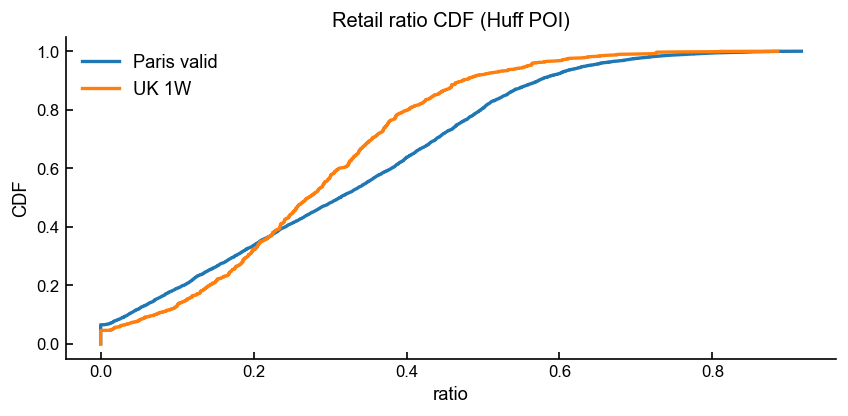

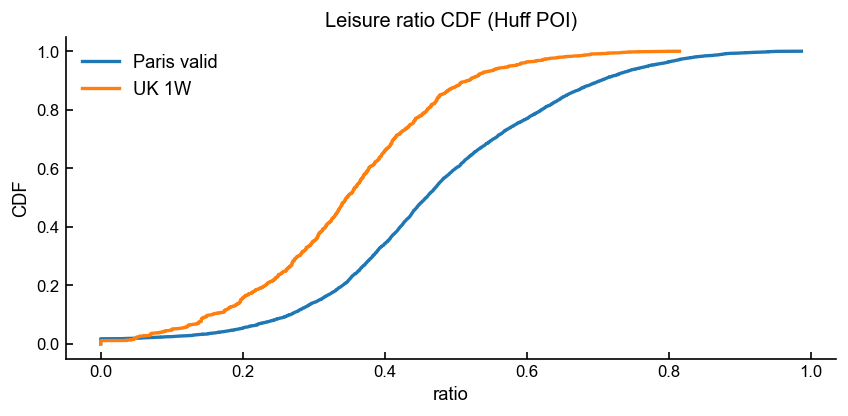

In [11]:
POI_COLS = ["poi_edu_cnt","poi_health_cnt","poi_retail_cnt","poi_leisure_cnt",
            "poi_transport_cnt","poi_accom_cnt","poi_office_cnt"]

# load Huff POI (latest UK)
paris_huff_path = OUT_DATA / "paris_poi_huff_k4_b1.5.parquet"
uk_huff_path = sorted(OUT_DATA.glob("uk_poi_huff_k4_b1.5_u*.parquet"))[-1]

paris_poi_huff = pd.read_parquet(paris_huff_path)
uk_poi_huff = pd.read_parquet(uk_huff_path)

# attach to stays
def attach_poi(stays, poi_df):
    cols = ["hex_id"] + POI_COLS + ["poi_total_cnt"]
    return stays.merge(poi_df[cols], on="hex_id", how="left").fillna(0)

paris_valid_h = attach_poi(paris_valid, paris_poi_huff)
uk_1w_h = attach_poi(uk_1w, uk_poi_huff)

def ratio_stats(d):
    sem = d["poi_edu_cnt"] + d["poi_health_cnt"] + d["poi_retail_cnt"] + d["poi_leisure_cnt"]
    out = pd.DataFrame({
        "edu_ratio": d["poi_edu_cnt"]/(sem+1.0),
        "health_ratio": d["poi_health_cnt"]/(sem+1.0),
        "retail_ratio": d["poi_retail_cnt"]/(sem+1.0),
        "leisure_ratio": d["poi_leisure_cnt"]/(sem+1.0),
        "sem_total": sem,
        "poi_total_cnt": d["poi_total_cnt"]
    })
    return out

paris_rat = ratio_stats(paris_valid_h)
uk_rat = ratio_stats(uk_1w_h)

print("Paris VALID Huff POI ratios:")
print(paris_rat[["edu_ratio","health_ratio","retail_ratio","leisure_ratio"]].describe(percentiles=[0.5,0.9,0.95,0.99]))

print("\nUK 1W Huff POI ratios:")
print(uk_rat[["edu_ratio","health_ratio","retail_ratio","leisure_ratio"]].describe(percentiles=[0.5,0.9,0.95,0.99]))

# Simple CDF plot for retail/leisure ratios
def plot_cdf(series_a, series_b, label_a="Paris", label_b="UK", title="CDF"):
    a = np.sort(series_a.dropna().values)
    b = np.sort(series_b.dropna().values)
    ya = np.linspace(0, 1, len(a), endpoint=False)
    yb = np.linspace(0, 1, len(b), endpoint=False)

    plt.figure(figsize=(7.2, 3.6))
    plt.plot(a, ya, label=label_a)
    plt.plot(b, yb, label=label_b)
    plt.xlabel("ratio")
    plt.ylabel("CDF")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_cdf(paris_rat["retail_ratio"], uk_rat["retail_ratio"],
         label_a="Paris valid", label_b="UK 1W", title="Retail ratio CDF (Huff POI)")
plot_cdf(paris_rat["leisure_ratio"], uk_rat["leisure_ratio"],
         label_a="Paris valid", label_b="UK 1W", title="Leisure ratio CDF (Huff POI)")

<AxesSubplot:>

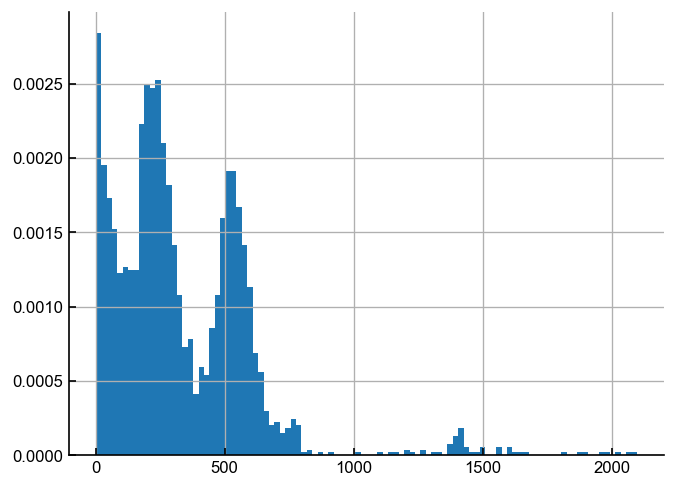

In [17]:
paris_valid[paris_valid['y_true']=="WORK"]['duration_min'].hist(bins=100, density=True)